Below is a **clear, practical, production-style explanation of handling corrupt records in Spark**, explained in **layman terms**, with **examples**, **code**, and **what actually happens internally**.
This is **very commonly asked in interviews and real pipelines**.

---

# 🔹 What are Corrupt Records?

A **corrupt record** is a row that **does not match the expected schema**.

### Examples:

* Missing columns
* Extra columns
* Wrong data type
* Broken JSON / malformed CSV

Example bad CSV row:

```text
4,David,US,abc,2024-01-04   ← amount should be number
```

---

# 🔹 Base Example Data

### Expected Schema

```python
schema = "order_id INT, customer STRING, region STRING, amount INT, order_date DATE"
```

---

# 1️⃣ Handling Corrupt Records in CSV

## Example CSV file (`orders_bad.csv`)

```text
order_id,customer,region,amount,order_date
1,Alice,US,100,2024-01-01
2,Bob,EU,200,2024-01-02
3,Charlie,US,abc,2024-01-03   ← corrupt
4,David,US,150                ← corrupt
```

---


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# 1️⃣ Create Spark session
spark = SparkSession.builder \
    .appName("SimpleDataFrameExample") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 20:31:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/16 20:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/16 20:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/16 20:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/16 20:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
26/01/16 20:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
26/01/16 20:31:03 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.


NameError: name 'schema' is not defined

In [4]:
schema = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("customer", StringType(), True),
    StructField("region", StringType(), True),
    StructField("amount", IntegerType(), True),
    StructField("order_date", StringType(), True)
])

In [6]:
bad_df = spark.read \
  .option("header", "true") \
  .option("mode", "PERMISSIVE") \
  .option("columnNameOfCorruptRecord", "_corrupt_record") \
  .schema(schema) \
  .csv("/data/orders_bad.csv")

bad_df.show(truncate=False)

+--------+--------+------+------+-------------+
|order_id|customer|region|amount|order_date   |
+--------+--------+------+------+-------------+
|1       |Alice   |US    |100   |2024-01-01   |
|2       |Bob     |EU    |200   |2024-01-02   |
|3       |Charlie |US    |NULL  |2024-01-03   |
|4       |David   |US    |NULL  |NULL         |
+--------+--------+------+------+-------------+



In [7]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("customer", StringType(), True),
    StructField("region", StringType(), True),
    StructField("amount", IntegerType(), True),
    StructField("order_date", StringType(), True),
    StructField("_corrupt_record", StringType(), True)  # REQUIRED
])


In [8]:
bad_df = spark.read \
  .option("header", "true") \
  .option("mode", "PERMISSIVE") \
  .option("columnNameOfCorruptRecord", "_corrupt_record") \
  .schema(schema) \
  .csv("/data/orders_bad.csv")

bad_df.show(truncate=False)

+--------+--------+------+------+-------------+------------------------------+
|order_id|customer|region|amount|order_date   |_corrupt_record               |
+--------+--------+------+------+-------------+------------------------------+
|1       |Alice   |US    |100   |2024-01-01   |NULL                          |
|2       |Bob     |EU    |200   |2024-01-02   |NULL                          |
|3       |Charlie |US    |NULL  |2024-01-03   |3,Charlie,US,abc,2024-01-03   |
|4       |David   |US    |NULL  |NULL         |4,David,US,150                |
+--------+--------+------+------+-------------+------------------------------+



PERMISSIVE Mode (Default – Most Used)
What happens

Good rows are parsed

Bad rows go into _corrupt_record

Pipeline does not fail

In [10]:
corrupt_only = bad_df.filter("_corrupt_record IS NOT NULL")
corrupt_only.show(truncate=False)


+--------+--------+------+------+-------------+------------------------------+
|order_id|customer|region|amount|order_date   |_corrupt_record               |
+--------+--------+------+------+-------------+------------------------------+
|3       |Charlie |US    |NULL  |2024-01-03   |3,Charlie,US,abc,2024-01-03   |
|4       |David   |US    |NULL  |NULL         |4,David,US,150                |
+--------+--------+------+------+-------------+------------------------------+



In [11]:
corrupt_only.write \
  .mode("append") \
  .csv("/data/corrupt/orders/")


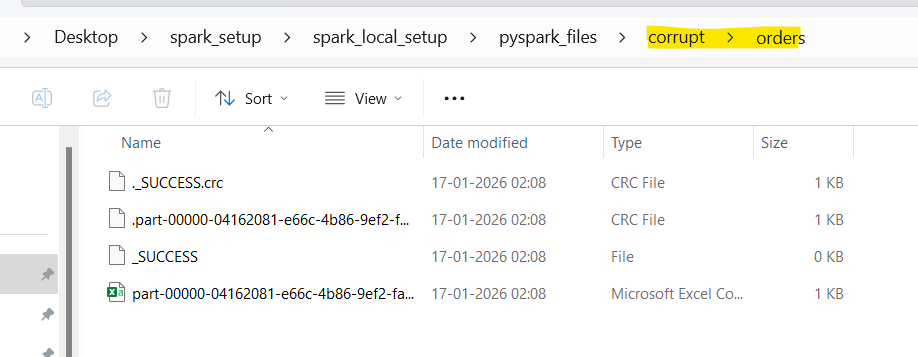

In [12]:
clean_df = bad_df.filter("_corrupt_record IS NULL") \
                 .drop("_corrupt_record")


In [13]:
clean_df.show()

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



DROPMALFORMED Mode (Silently Drop Bad Rows)
❌ Bad rows are lost
⚠️ Not recommended for financial data

In [14]:
drop_df = spark.read \
  .option("header", "true") \
  .option("mode", "DROPMALFORMED") \
  .schema(schema) \
  .csv("/data/orders_bad.csv")


In [15]:
drop_df.show()

+--------+--------+------+------+----------+---------------+
|order_id|customer|region|amount|order_date|_corrupt_record|
+--------+--------+------+------+----------+---------------+
|       1|   Alice|    US|   100|2024-01-01|           NULL|
|       2|     Bob|    EU|   200|2024-01-02|           NULL|
+--------+--------+------+------+----------+---------------+



FAILFAST Mode (Strict)
Job fails immediately
✅ Used when data quality must be perfect

In [18]:
df_failfast=spark.read \
  .option("header", "true") \
  .option("mode", "FAILFAST") \
  .schema(schema) \
  .csv("/data/orders_bad.csv")

In [19]:
df_failfast.show()

26/01/16 20:43:31 ERROR Executor: Exception in task 0.0 in stage 7.0 (TID 7)
org.apache.spark.SparkException: [MALFORMED_RECORD_IN_PARSING.WITHOUT_SUGGESTION] Malformed records are detected in record parsing: [3,Charlie,US,null,2024-01-03   ,3,Charlie,US,abc,2024-01-03   ].
Parse Mode: FAILFAST. To process malformed records as null result, try setting the option 'mode' as 'PERMISSIVE'. 
	at org.apache.spark.sql.errors.QueryExecutionErrors$.malformedRecordsDetectedInRecordParsingError(QueryExecutionErrors.scala:1610)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:79)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$2(UnivocityParser.scala:456)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(File

Py4JJavaError: An error occurred while calling o121.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 7.0 failed 1 times, most recent failure: Lost task 0.0 in stage 7.0 (TID 7) (5af74ef051d5 executor driver): org.apache.spark.SparkException: [MALFORMED_RECORD_IN_PARSING.WITHOUT_SUGGESTION] Malformed records are detected in record parsing: [3,Charlie,US,null,2024-01-03   ,3,Charlie,US,abc,2024-01-03   ].
Parse Mode: FAILFAST. To process malformed records as null result, try setting the option 'mode' as 'PERMISSIVE'. 
	at org.apache.spark.sql.errors.QueryExecutionErrors$.malformedRecordsDetectedInRecordParsingError(QueryExecutionErrors.scala:1610)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:79)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$2(UnivocityParser.scala:456)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.sql.catalyst.util.BadRecordException: java.lang.NumberFormatException: For input string: "abc"
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:365)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$parse$2(UnivocityParser.scala:307)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$1(UnivocityParser.scala:452)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:60)
	... 26 more
Caused by: java.lang.NumberFormatException: For input string: "abc"
	at java.base/java.lang.NumberFormatException.forInputString(Unknown Source)
	at java.base/java.lang.Integer.parseInt(Unknown Source)
	at java.base/java.lang.Integer.parseInt(Unknown Source)
	at scala.collection.immutable.StringLike.toInt(StringLike.scala:310)
	at scala.collection.immutable.StringLike.toInt$(StringLike.scala:310)
	at scala.collection.immutable.StringOps.toInt(StringOps.scala:33)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6(UnivocityParser.scala:189)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6$adapted(UnivocityParser.scala:189)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.nullSafeDatum(UnivocityParser.scala:291)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$5(UnivocityParser.scala:189)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:346)
	... 29 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: [MALFORMED_RECORD_IN_PARSING.WITHOUT_SUGGESTION] Malformed records are detected in record parsing: [3,Charlie,US,null,2024-01-03   ,3,Charlie,US,abc,2024-01-03   ].
Parse Mode: FAILFAST. To process malformed records as null result, try setting the option 'mode' as 'PERMISSIVE'. 
	at org.apache.spark.sql.errors.QueryExecutionErrors$.malformedRecordsDetectedInRecordParsingError(QueryExecutionErrors.scala:1610)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:79)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$2(UnivocityParser.scala:456)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: org.apache.spark.sql.catalyst.util.BadRecordException: java.lang.NumberFormatException: For input string: "abc"
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:365)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$parse$2(UnivocityParser.scala:307)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$1(UnivocityParser.scala:452)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:60)
	... 26 more
Caused by: java.lang.NumberFormatException: For input string: "abc"
	at java.base/java.lang.NumberFormatException.forInputString(Unknown Source)
	at java.base/java.lang.Integer.parseInt(Unknown Source)
	at java.base/java.lang.Integer.parseInt(Unknown Source)
	at scala.collection.immutable.StringLike.toInt(StringLike.scala:310)
	at scala.collection.immutable.StringLike.toInt$(StringLike.scala:310)
	at scala.collection.immutable.StringOps.toInt(StringOps.scala:33)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6(UnivocityParser.scala:189)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6$adapted(UnivocityParser.scala:189)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.nullSafeDatum(UnivocityParser.scala:291)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$5(UnivocityParser.scala:189)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:346)
	... 29 more


Handling Corrupt JSON
Bad JSON Example

In [32]:
json_df = (
    spark.read
      .option("mode", "PERMISSIVE")
      .option("columnNameOfCorruptRecord", "_corrupt_record")
      .schema(schema)
      .json("/data/orders_bad_permissive.json")
)

json_df.show(truncate=False)


+--------+--------+------+------+----------+------------------------------------------------------------------------------------------+
|order_id|customer|region|amount|order_date|_corrupt_record                                                                           |
+--------+--------+------+------+----------+------------------------------------------------------------------------------------------+
|1       |Alice   |US    |100   |2024-01-01|NULL                                                                                      |
|2       |Bob     |EU    |200   |2024-01-02|NULL                                                                                      |
|3       |Charlie |US    |NULL  |2024-01-03|{"order_id":3,"customer":"Charlie","region":"US","amount":"abc","order_date":"2024-01-03"}|
|4       |David   |US    |150   |NULL      |NULL                                                                                      |
+--------+--------+------+------+----------+----



# 5️⃣ Corrupt Records in Parquet

⚠️ **Parquet does NOT support corrupt-record handling like CSV/JSON**

### Why?

* Parquet is binary & schema-enforced
* Bad data usually fails **before write**
* Corruption = file-level issue

### What you do instead:

* Validate **before writing**
* Use **schema enforcement**
* Reprocess failed files

---

---

# 7️⃣ Common Interview Questions (with Answers)

### Q: Why is PERMISSIVE mode preferred?

> Because pipelines don’t fail, and bad data can be reviewed later.

### Q: Can Parquet handle corrupt records?

> No. Parquet enforces schema strictly; corrupt data must be handled before writing.

### Q: What happens if schema is not provided?

> Spark infers schema → slow and error-prone.

---

# 🔚 Final Summary (Remember This)

| Format  | Supports Corrupt Record Handling |
| ------- | -------------------------------- |
| CSV     | ✅ Yes                            |
| JSON    | ✅ Yes                            |
| Parquet | ❌ No                             |

| Mode          | Behavior       |
| ------------- | -------------- |
| PERMISSIVE    | Keeps bad rows |
| DROPMALFORMED | Drops bad rows |
| FAILFAST      | Fails job      |

---



Real Production Pattern (Best Practice)

### Step-by-step Pipeline

```python
raw_df = spark.read \
  .option("mode", "PERMISSIVE") \
  .option("columnNameOfCorruptRecord", "_corrupt_record") \
  .schema(schema) \
  .csv("/landing/orders/")
```

```python
good_df = raw_df.filter("_corrupt_record IS NULL")
bad_df  = raw_df.filter("_corrupt_record IS NOT NULL")
```

```python
good_df.write.parquet("/curated/orders/")
bad_df.write.json("/quarantine/orders/")
```

📌 This is called **Quarantine Pattern**


In [29]:
!ls /data

corrupt		   orders_bad_permissive.json  orders_partitioned_csv
employee.csv	   orders_csv		       orders_partitioned_json
employee.json	   orders_csv_bucketed	       orders_partitioned_parquet
employees.parquet  orders_json
orders_bad.csv	   orders_parquet
